# CLEAN-T 

This script is an example of use of CleanT Class in DeconvolutionMethods library using time domain generated signal simulated using the Simulations library.


- Test Case : Moving source with rotation on 3 axes
- Analysis : Single CLEAN-T analysis along all the trajectory

## Sparse trajectory samplerate

In [ ]:
from cleantipy.Propagation import MovingSrcSimu_t
import numpy as np
import pylab as pl
import scipy.io as io
from Sarradj_2016_array import MicArrayGeom
from cleantipy.DeconvolutionMethods import CleanT

# Set the default figure facecolor to transparent
pl.rcParams['figure.facecolor'] = 'none'
# Set the default axes facecolor to white
pl.rcParams['axes.facecolor'] = 'white'

# Set to "True" if forcing recomputation is needed
compute = True

### Parameters 

In [2]:
pref = 2*10**-5 #Pa
fs = 10000
T = 3
Nt = int(fs*T)
t = np.arange(T*fs)/fs 

fs_traj = 4 # 4 GPS points per seceonds
Nt_ = T*fs_traj+1
t_traj = np.arange(Nt_)/fs_traj

# Agngles setup
ang = np.array([(1-np.cos(t_traj/2))/2,0*t_traj,-(1-np.cos(t_traj/2))/3]).T

# Trajectory setup
v = 100   # m/s
Z = 150 # m
Y = 0   # m
X = np.arange(Nt_)*v/fs_traj - T*v/2    # m
traj = np.array([X,Y*np.ones(Nt_),Z*np.ones(Nt_)]).T

# Adding rotations
traj += np.array([0*np.arange(Nt_),-(1-np.cos(t_traj/2))*180/np.pi,0*np.arange(Nt_)]).T

# Micropophone array geometry setup
Nmic = 256
x, y = MicArrayGeom(Nmic,h=2)
z_array = 0

geom = np.array([x,y,z_array*np.ones((Nmic))]).T

# Source definition (position and signal)
sig = np.array([np.random.randn(Nt), # white noise - Theoretical noise level : 93.9 dB
                np.sin(2*np.pi*440*2*t), # 880 Hz sine - Theoretical noise level : 91 dB
                np.sin(2*np.pi*440*t)]) # 440 Hz sine - Theoretical noise level : 91 dB
pos = np.array([[10,0,0],
                [0,10,0],
                [0,-10,0]]) # relative position to the trajectory

### Run or load the microphone signals

** Computing microphone signals **


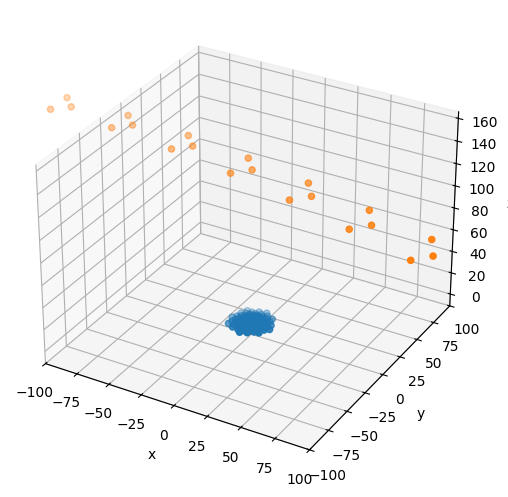

In [3]:

# Define simulation object
simu = MovingSrcSimu_t(geom, pos, traj, t, sig, t_traj=t_traj, angles=ang, SNR=60, timeOrigin='source')


simu.plot()
ax = pl.gca()        
ax.set_xlim(-100,100)
ax.set_ylim(-100,100)


#%% Compute simulated pressures
if compute: 
    try:
        print("** Computing microphone signals **")
        simu.compute(parrallel=True,interpolation="quadratic")
        Sig = simu.p_t
        io.savemat('SimuAngles.mat',{'Sig':Sig})
    except :
        tmp = io.loadmat('SimuAngles.mat',variable_names=['Sig'])
        Sig = tmp['Sig']

else:
    try:
        tmp = io.loadmat('SimuAngles.mat',variable_names=['Sig'])
        Sig = tmp['Sig']
    except :
        print("** SimuAngles.mat not found: Computing microphone signals **")
        simu.compute(parrallel=True,interpolation="quadratic")
        Sig = simu.p_t
        io.savemat('SimuAngles.mat',{'Sig':Sig})

del simu


### Define reconstruction grid and set CLEAN-T object


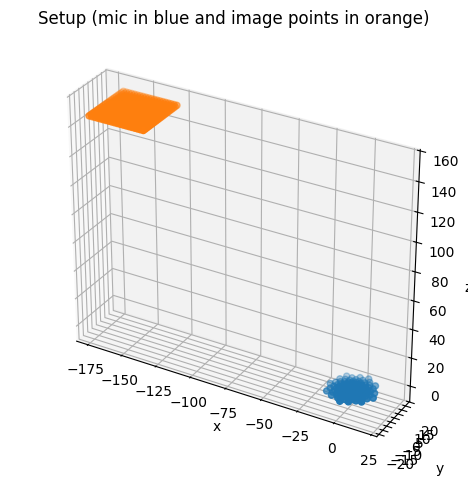

In [4]:
#%% define image plan relatively to the trajectory
Lx = 40
Ly = 40
resX = 2
resY = 2
x_F = np.arange(0,Lx,resX)-Lx/2
y_F = np.arange(0,Ly,resY)-Ly/2
z_F = 0 
X_F, Y_F, Z_F = np.meshgrid(x_F,y_F,z_F)
grid = np.array([X_F.reshape(-1),Y_F.reshape(-1),Z_F.reshape(-1)]).T



#%% Define and compute CLEAN-T
cleant = CleanT(geom,grid,traj,t,Sig,ang,t_traj,debug=False,monitor=False)

cleant.bf.plot()
ax=pl.gca()
ax.set_aspect('equal')

### Compute CLEAN-T

In [5]:
print('\n')
print(69*'*')
print("** Starting CLEAN-T computation on a grid following the trajectory **")
print(69*'*')

# cleant.bf.QuantitativeComputation=True
cleant.compute(parrallel=True)



*********************************************************************
** Starting CLEAN-T computation on a grid following the trajectory **
*********************************************************************


KeyboardInterrupt: 

### Display results

Detailed information of identified sources (full signal used for noise level computation):
Tonal     - 89.8 dB - Pos.: x:0.0	y:-10.0	z:0.0 (rel. traj.) - E: 100.0%
Tonal     - 89.7 dB - Pos.: x:0.0	y:10.0	z:0.0 (rel. traj.) - E: 57.6%
Broadband - 91.5 dB - Pos.: x:10.0	y:0.0	z:0.0 (rel. traj.) - E: 46.5%


Beamforming vs CLEAN-T (noise level computation only on not-zero part of the source signals)


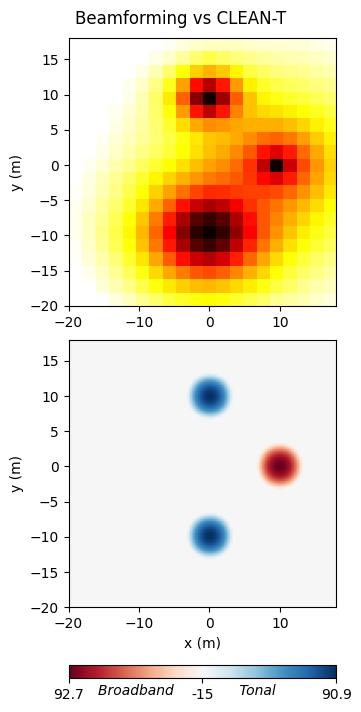

In [ ]:

print("Detailed information of identified sources (full signal used for noise level computation):")
cleant.printSourceData()

#%% Display results on grid along the trajectory

dyn = 15 # Dynamic range of results display in dB
normalisedByMax = False # if True, data are normalised by maximum, if False dislay is given in dB ref 20µPa

# sigThreshold is the value above which the signal is considered for noise level computing 
# (as zeros can set at the end of the reconscruted signals, it's better not to use it for source power estimation)
cleant.CleantMap(gauss=True,dyn=dyn,sameDynRange=False,adym=normalisedByMax,sigThreshold=2e-2)

print('\n')
print("Beamforming vs CLEAN-T (noise level computation only on not-zero part of the source signals)")

fig, axs = pl.subplots(2,1, 
                       constrained_layout=True,figsize=(3.5,7))
fig.suptitle('Beamforming vs CLEAN-T')

ax = axs[0]
BF_dB = cleant.Sources[0]['AcousticMap'].reshape((y_F.size,x_F.size))        
mx = np.max(BF_dB)
ax.imshow(BF_dB, vmax=mx, vmin=mx-dyn, \
        origin='lower',cmap='hot_r',\
            extent=[x_F[0],x_F[-1],y_F[0],y_F[-1]])
ax.set_ylabel('y (m)')

pl.ylabel('y (m)')
# fig.colorbar(ax=ax)
pl.xlabel('x (m)')

ax = axs[1]
img = ax.imshow(cleant.q_disp, origin='lower',
          extent=[x_F[0],x_F[-1],y_F[0],y_F[-1]], cmap='RdBu',
          vmin=-dyn,vmax=dyn,interpolation_stage='data')
cbar = fig.colorbar(img, ax=ax,ticks=[-dyn, 0, dyn],location="bottom")

if normalisedByMax:
    cbar.ax.set_xticklabels([0, -dyn, 0])
else:
    cbar.ax.set_xticklabels(['%.1f' %(cleant.qmax_bb),\
                            '%d' %(-dyn), '%.1f' %(cleant.qmax_ton)])

# cbar.ax.set_title('[dB]')
cbar.set_label('Broadband               Tonal       ', fontstyle='italic', labelpad=-13)

## High tranejctory samplerate (memory intensive version)

**This is an example with a trajectory samplerate equal to the microphone signal samplerate.**

**Advice: This script is a demonstartor, showcasing the possibility to have trajectory with different samplerates, but our recomandation is always to work with a minimal samplerate for the trajectory, otherwise it's very memory (and time) consuming**

- Test Case : Moving source with rotation on 3 axes
- Analysis : Single CLEAN-T analysis along all the trajectory

### Parameters 

In [ ]:


pref = 2*10**-5 #Pa
fs = 10000
T = 3
Nt = int(fs*T)
t = np.arange(T*fs)/fs 


# Agngles setup
ang = np.array([(1-np.cos(np.arange(Nt)/fs/2))/2,0*np.arange(Nt),-(1-np.cos(np.arange(Nt)/fs/2))/3]).T


# Trajectory setup
v = 100   # m/s
Z = 150 # m
Y = 0   # m
X = np.arange(Nt)*v/fs - T*v/2    # m
traj = np.array([X,Y*np.ones(Nt),Z*np.ones(Nt)]).T

# Adding rotations
traj += np.array([0*np.arange(Nt),-(1-np.cos(np.arange(Nt)/fs/2))*180/np.pi,0*np.arange(Nt)]).T


# Micropophone array geometry setup
Nmic = 256
x, y = MicArrayGeom(Nmic,h=2)
z_array = 0

geom = np.array([x,y,z_array*np.ones((Nmic))]).T

# Source definition (position and signal)
sig = np.array([np.random.randn(Nt), # white noise
                np.sin(2*np.pi*440*2*t), # 880 Hz sine
                np.sin(2*np.pi*440*t)]) # 440 Hz sine
pos = np.array([[10,0,0],
                [0,10,0],
                [0,-10,0]]) # relative position to the trajectory

### Run or load the microphone signals

Propagation : assuming trajectory has the same sampling frequency and time origin as mic signals
** Computing microphone signals **


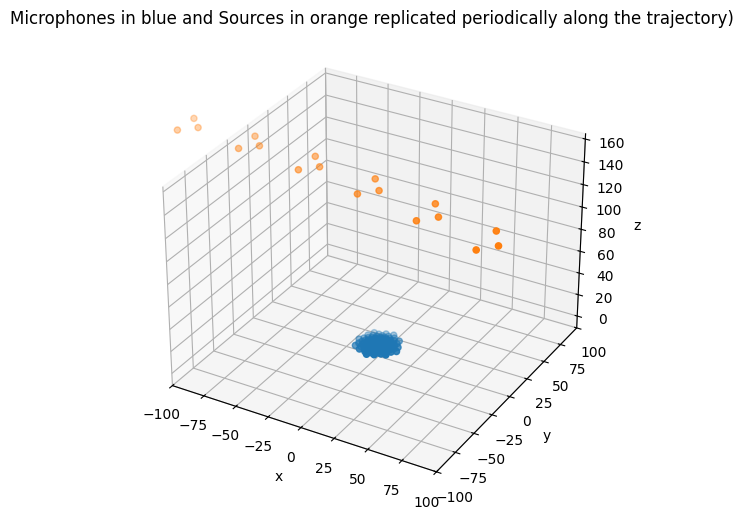

In [ ]:

# Define simulation object
simu = MovingSrcSimu_t(geom, pos, traj, t, sig, angles=ang, SNR=60, timeOrigin='source')


simu.plot()
ax = pl.gca()        
ax.set_xlim(-100,100)
ax.set_ylim(-100,100)
pl.title("Microphones in blue and Sources in orange replicated periodically along the trajectory)")


#%% Compute simulated pressures
if compute: 
    try:
        print("** Computing microphone signals **")
        simu.compute(parrallel=True,interpolation="quadratic")
        Sig = simu.p_t
        io.savemat('SimuAngles.mat',{'Sig':Sig})
    except :
        tmp = io.loadmat('SimuAngles.mat',variable_names=['Sig'])
        Sig = tmp['Sig']

else:
    tmp = io.loadmat('SimuAngles.mat',variable_names=['Sig'])
    Sig = tmp['Sig']

del simu

### Define reconstruction grid for CLEAN-T and set CLEAN-T object



*********************************************************************
** Starting CLEAN-T computation on a grid following the trajectory **
*********************************************************************
Beamforming : assuming trajectory has the same sampling frequency and time origin as mic signals


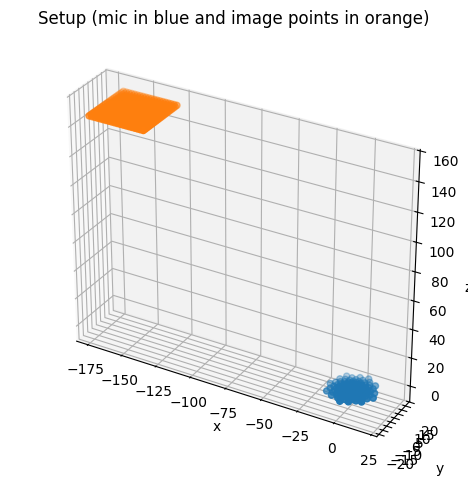

In [ ]:
#%% define image plan relatively to the trajectory
Lx = 40
Ly = 40
resX = 2
resY = 2
x_F = np.arange(0,Lx,resX)-Lx/2
y_F = np.arange(0,Ly,resY)-Ly/2
z_F = 0 
X_F, Y_F, Z_F = np.meshgrid(x_F,y_F,z_F)
grid = np.array([X_F.reshape(-1),Y_F.reshape(-1),Z_F.reshape(-1)]).T


#%% Define and compute CLEAN-T
print('\n')
print(69*'*')
print("** Starting CLEAN-T computation on a grid following the trajectory **")
print(69*'*')

cleant = CleanT(geom,grid,traj,t,Sig,ang,debug=False,monitor=False)

cleant.bf.plot()
ax=pl.gca()
ax.set_aspect('equal')


### Compute CLEAN-T

In [ ]:
# cleant.bf.QuantitativeComputation=True
cleant.compute(parrallel=True)

0 - Residual energy: 100.0%
1 - Residual energy: 59.5%
2 - Residual energy: 49.0%
3 - Residual energy: 0.2%
Residual energy inferior to stop criterion : 5%


### Display results

Tonal     - 90.1 dB - Pos.: x:0.0	y:-10.0	z:0.0 (rel. traj.) - E: 100.0%
Tonal     - 90.1 dB - Pos.: x:0.0	y:10.0	z:0.0 (rel. traj.) - E: 59.5%
Broadband - 91.9 dB - Pos.: x:10.0	y:0.0	z:0.0 (rel. traj.) - E: 49.0%


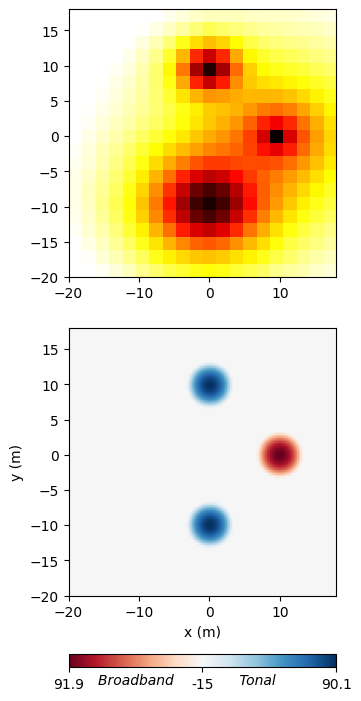

In [ ]:
cleant.printSourceData()

#%% Display results on grid along the trajectory

dyn = 15 # Dynamic range of results display in dB
normalisedByMax = False # if True, data are normalised by maximum, if False dislay is given in dB ref 20µPa

cleant.CleantMap(gauss=True,dyn=dyn,sameDynRange=False,adym=normalisedByMax)

fig, axs = pl.subplots(2,1, 
                       num='CLEAN-T vs BF', 
                       constrained_layout=True,figsize=(3.5,7))
ax = axs[0]
BF_dB = cleant.Sources[0]['AcousticMap'].reshape((y_F.size,x_F.size))        
mx = np.max(BF_dB)
ax.imshow(BF_dB, vmax=mx, vmin=mx-dyn, \
        origin='lower',cmap='hot_r',\
            extent=[x_F[0],x_F[-1],y_F[0],y_F[-1]])
pl.ylabel('y (m)')
# fig.colorbar(ax=ax)
pl.xlabel('x (m)')

ax = axs[1]
img = ax.imshow(cleant.q_disp, origin='lower',
          extent=[x_F[0],x_F[-1],y_F[0],y_F[-1]], cmap='RdBu',
          vmin=-dyn,vmax=dyn,interpolation_stage='data')
cbar = fig.colorbar(img, ax=ax,ticks=[-dyn, 0, dyn],location="bottom")
if normalisedByMax:
    cbar.ax.set_xticklabels([0, -dyn, 0])
else:
    cbar.ax.set_xticklabels(['%.1f' %(cleant.qmax_bb),\
                            '%d' %(-dyn), '%.1f' %(cleant.qmax_ton)])

# cbar.ax.set_title('[dB]')
cbar.set_label('Broadband               Tonal       ', fontstyle='italic', labelpad=-13)